# Transformer机器翻译（英译中）

本文件是集智学园开发的“大数据驱动的人工智能”系列课程第九节课：《从 Transformer 到 ChatGPT》的配套文档。在本文档中，我们将使用CWMT数据集从头训练Transformer模型进行中英文翻译。

以下为主要步骤：

0. 安装需要的工具包
1. 从中英文语料库读取训练集、验证集和测试集，进行分词等预处理操作，构建词典
2. 实现Transformer编码器的注意力机制
3. 实现Transformer编码器的其它部分
4. 实现Transformer解码器部分
5. 完整实现Transformer模型架构
6. Transformermo模型的优化方法和技巧
7. 定义训练过程，训练模型，可视化训练Loss
8. 使用greedy_decode方法完成翻译任务，使用BLEU指标评价
9. 打印模型翻译结果和BLEU评分，思考评分低的原因以及改进措施。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码

# 0. 安装需要的工具包

In [1]:
!pip install nltk # 安装自然语言处理工具包nltk，用于英文句子分词
!pip install seaborn # 安装可视化工具包seaborn
!pip install jieba # 安装自然语言处理工具包jieba，用于中文句子分词

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 1.5 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 94.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 772 kB 85.8 MB/s eta 0:00:01
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 292 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.3 MB 47.5 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 72.2 MB/s eta 0:00:01
     |████████████████████████████████| 340 kB 94.1 MB/s eta 0:00:01
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 19.2 MB 1.7 MB/s eta 0:00:01    |▎                               | 184 kB 1.7 MB/s eta 0:00:11     |██████████████████████          | 13.2 MB 1.7 MB/s eta 0:00:04
  Created wheel for jieba: fil

In [1]:
import os # 系统库，用于操作文件、路径等
import math # 数学库，用于数学计算
import copy # 复制库，用于对象复制
import time # 时间库，用于计时
import numpy as np # 数组库，用于数组操作
import nltk # 用于英文句子分词
import jieba # 用于中文句子分词
import torch # PyTorch库，用于深度学习
import torch.nn as nn # PyTorch神经网络模块，用于神经网络层的搭建
import torch.nn.functional as F #  PyTorch神经网络模块，用于激活函数等
from nltk import word_tokenize # NLTK库，用于自然语言处理中的分词
from collections import Counter # 集合库，用于计数
from torch.autograd import Variable # PyTorch库，用于自动求导
import seaborn as sns # 数据可视化库，用于绘制图形
import matplotlib.pyplot as plt # 数据可视化库，用于绘制图形

In [3]:
nltk.data.path.append(os.path.expanduser('~/nltk_data'))
print(os.path.expanduser('~/nltk_data'))
nltk.download('punkt', download_dir=os.path.expanduser('~/nltk_data'))
#需要保证punkt文件夹中存在english.pickle，用于英文句子分词
#若此代码未能正常运行，需手动添加文件english.pickle，路径例如：/root/nltk_data/tokenizers/punkt/PY3/english.pickle

/root/nltk_data


[nltk_data] Downloading package punkt to /root/nltk_data...


KeyboardInterrupt: 

# 1. 从中英文语料库读取训练集、验证集和测试集。分词等预处理操作，构建词典。

下面这段代码主要是定义了一些参数和变量，包括未知单词的ID、填充单词的ID、批量大小、训练轮数、层数、头数、模型的输入和输出向量大小、前馈网络的中间维数、dropout比率、句子的最大长度等。
同时还定义了训练、开发和测试文件的文件名，以及保存模型的文件名。最后根据可用的设备设置了设备类型。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [2]:
UNK = 0 # 未知词标记（表示词典中未收录的词）
PAD = 1 # 填充标记（用于将不同长度的序列填充至相同长度）
BATCH_SIZE = 64 # 批处理大小
EPOCHS  = 40 # 训练周期数
LAYERS  = 6 # Transformer层数
H_NUM   = 8 # 多头注意力机制的头数  
D_MODEL = 256 # 模型中的嵌入维度 
D_FF    = 1024 # 前馈神经网络的隐藏层维度   
DROPOUT = 0.1 # Dropout比率    
MAX_LENGTH = 60 # 句子的最大长度  

# 训练、校验和测试文件路径
TRAIN_FILE = ['en_train.txt','ch_train.txt']  
VALID_FILE   = ['en_valid.txt','ch_valid.txt']
TEST_FILE = ['en_test.txt','ch_test.txt']
SAVE_FILE  = 'large_model.pt'  

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

下面这段代码定义了一个名为Batch的类，它在训练过程中用于保存一批数据及其相应的掩码。subsequent_mask函数用于生成一个掩码矩阵，在Batch类的make_std_mask静态方法中被调用，用于在自注意力机制中防止使用未来的信息。


本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [3]:
def subsequent_mask(size):
    
    # 创建一个三维的矩阵，其形状为(1, size, size)
    attn_shape = (1, size, size) 
    # 上三角矩阵, 只保留对角线以下元素，其它为0
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') 
    # 将numpy数组转换为pytorch的张量类型，并对上三角部分赋值为True，下三角及对角线赋值为False
    return torch.from_numpy(subsequent_mask) == 0

class Batch:
    
    # 初始化函数，输入为src，trg和pad，其中src是源语言句子序列，trg是目标语言句子序列，pad是填充字符的id
    def __init__(self, src, trg=None, pad=0): 
        # 将src和trg转换为PyTorch张量格式。
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        # 保存源句子，并创建一个与源句子形状相同的掩码，其中填充符号的位置被标记为0，其他位置为1。
        self.src = src
        # 使用(src != pad)生成src的掩码，值为True或False
        # 为了使掩码与查询矩阵的维度相同，使用unsqueeze方法在维度上扩展，以便于它们在softmax计算中进行广播。
        self.src_mask = (src != pad).unsqueeze(-2) 
        # 如果目标句子（trg）不是空的，则将其拆分为两个部分，一个包含所有位置除了最后一个位置（self.trg），另一个包含所有位置除了第一个位置（self.trg_y）。
        if trg is not None:
            self.trg = trg[:, :-1] # 如果trg不为空，则使用trg生成self.trg，其中self.trg是从trg中排除了最后一个字符的序列
            self.trg_y = trg[:, 1:] # 生成self.trg_y，其中self.trg_y是trg中从第二个字符开始的序列
            self.trg_mask = self.make_std_mask(self.trg, pad) # 生成一个特殊的mask来表示哪些标记应该由self-attention遮盖，这是由make_std_mask函数完成的
            self.ntokens = (self.trg_y != pad).data.sum() # 计算ntokens，即在self.trg_y中的非pad字符数，以便在后面的训练中使用
    
    # make_std_mask是一个静态方法，它根据输入的tgt生成一个掩码tgt_mask
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2) # 创建一个tgt掩码来表示哪些标记应该由self-attention遮盖
        # 生成一个用于遮盖将来标记的掩码，以避免在解码期间使用将来的标记
        # 通过在广播的掩码和将来的掩码之间进行逐元素与运算生成掩码tgt_mask
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)) 
        return tgt_mask

下面这段代码中的 PrepareData 类封装了对训练集、开发集和测试集数据进行预处理所需的功能，包括将英文和中文句子分别转换为ID表示、将数据划分为若干个批次等操作。其中，seq_padding 函数用于对句子进行填充，使得长度相同；load_data 函数用于加载数据；build_dict 函数用于构建词典；wordToID 函数用于将句子转换为ID表示；splitBatch 函数用于将数据划分为批次。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [4]:
# X: 输入数据，为一个列表，其中每个元素代表一条数据；padding:填充的值，默认为0；
def seq_padding(X, padding=0): 
    L = [len(x) for x in X] # 获取每条数据的长度
    ML = max(L) # 获取最大长度
    return np.array([ # 返回填充后的numpy数组
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

# 名为 PrepareData 的类，用于对数据进行预处理
class PrepareData:
    # 初始化函数，加载数据并构建词典，将训练集和开发集转换为ID表示；train_file: 训练数据文件路径；valid_file: 校验数据文件路径；test_file: 测试数据文件路径
    def __init__(self, train_file, valid_file,test_file):
        
        self.train_en, self.train_cn = self.load_data(train_file[0],train_file[1]) # 加载训练集英文和中文数据
        self.valid_en, self.valid_cn = self.load_data(valid_file[0],valid_file[1]) # 加载校验集英文和中文数据
        self.test_en, self.test_cn = self.load_data(test_file[0],test_file[1]) # 加载测试集英文和中文数据
        print("train_en : ",len(self.train_en))
        print("train_cn : ",len(self.train_cn))
        print("valid_en : ",len(self.valid_en))
        print("valid_cn : ",len(self.valid_cn))
        print("test_en : ",len(self.test_en))
        print("test_cn : ",len(self.test_cn))
        print("valid_en[:5] : ",self.valid_en[:3])
        print("valid_cn[:5] : ",self.valid_cn[:3])
        
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en) # 构建英文词典
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)  # 构建中文词典
        
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict) # 将训练集英文和中文数据转换为ID表示
        self.valid_en, self.valid_cn = self.wordToID(self.valid_en, self.valid_cn, self.en_word_dict, self.cn_word_dict) # 将校验集英文和中文数据转换为ID表示
        self.test_en, self.test_cn = self.wordToID(self.test_en, self.test_cn, self.en_word_dict, self.cn_word_dict) # 将校验集英文和中文数据转换为ID表示
        
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE) # 划分批次，获取训练数据
        self.valid_data = self.splitBatch(self.valid_en, self.valid_cn, BATCH_SIZE) # 划分批次，获取校验数据
        self.test_data = self.splitBatch(self.test_en, self.test_cn, BATCH_SIZE) # 划分批次，获取测试数据
        
    
    # 加载数据函数；en_path: 英文数据文件路径；cn_path: 中文数据文件路径
    def load_data(self, en_path, cn_path):
        en = [] # 存储英文句子
        with open(en_path, 'r', encoding='utf-8') as f:
            
            for line in f: # 逐行读取英文数据文件
                line = line.strip().split('\t') # 将每行数据按制表符分割
                
                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"]) # 将英文句子分割成单词列表，并添加开始和结束符号
        cn = [] # 存储中文句子
        ii = 0
        with open(cn_path, 'r', encoding='utf-8') as f:
            for line in f: # 逐行读取中文数据文件
                line = line.strip().split('\t') # 将每行数据按制表符分割
                cn.append(["BOS"] + list(jieba.cut(line[0])) + ["EOS"])# 将中文句子分割成单词列表，并添加开始和结束符号
        return en, cn
    
    # 构建词典函数；sentences: 句子列表，其中每个元素为单词列表；max_words: 词典最大词数，默认为50000
    def build_dict(self, sentences, max_words = 50000):
        word_count = Counter() # 统计单词出现次数的字典
        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1 # 统计每个单词出现的次数

        ls = word_count.most_common(max_words) # 统计出现频率最高的max_words个单词
        total_words = len(ls) + 2 # 词典中单词总数，包括UNK和PAD
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)} # 构建单词到ID的映射字典，UNK和PAD分别对应0和1
        word_dict['UNK'] = UNK # 将UNK的ID赋值为0
        word_dict['PAD'] = PAD # 将PAD的ID赋值为1
        index_dict = {v: k for k, v in word_dict.items()} # 构建ID到单词的映射字典
        return word_dict, total_words, index_dict # 返回单词到ID的映射字典、词典中单词总数、ID到单词的映射字典
    
    # 将句子转换为ID表示函数；en: 英文句子列表，其中每个元素为单词列表；cn: 中文句子列表，其中每个元素为单词列表；en_dict: 英文单词到ID的映射字典
    # cn_dict: 中文单词到ID的映射字典；sort: 是否按句子长度排序，默认为True
    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        length = len(en)
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en] # 将英文句子列表转换为ID表示
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn] # 将中文句子列表转换为ID表示

        def len_argsort(seq):
            return sorted(range(len(seq)), key=lambda x: len(seq[x])) # 按句子长度排序的函数

        if sort: # 是否按句子长度排序
            sorted_index = len_argsort(out_en_ids) # 对英文句子按长度排序
            out_en_ids = [out_en_ids[id] for id in sorted_index] # 根据排序后的下标获取排序后的英文句子列表
            out_cn_ids = [out_cn_ids[id] for id in sorted_index] # 根据排序后的下标获取排序后的中文句子列表
        return out_en_ids, out_cn_ids # 返回英文和中文句子的ID表示
    
    # 将数据划分为批次的函数；en: 英文句子列表，其中每个元素为ID列表；cn: 中文句子列表，其中每个元素为ID列表；
    # batch_size: 批次大小；shuffle: 是否打乱顺序，默认为True
    def splitBatch(self, en, cn, batch_size, shuffle=True):
        idx_list = np.arange(0, len(en), batch_size) # 根据批次大小生成下标列表
        if shuffle: 
            np.random.shuffle(idx_list) # 打乱下标列表
            
        # 将下标列表划分为若干个批次
        batch_indexs = []
        for idx in idx_list:
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
        
        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index] # 根据批次下标获取英文句子列表
            batch_cn = [cn[index] for index in batch_index] # 根据批次下标获取中文句子列表
            batch_cn = seq_padding(batch_cn) # 对中文句子进行填充，使其长度相同
            batch_en = seq_padding(batch_en) # 对英文句子进行填充，使其长度相同
            batches.append(Batch(batch_en, batch_cn)) # 将填充后的英文和中文句子封装成Batch对象，并添加到批次列表中
        return batches # 返回批次列表

下面这段代码定义了一个名为Embeddings的PyTorch模块，它包含一个嵌入层（nn.Embedding），用于将单词ID转换为嵌入向量表示。构造函数（__init__）接受两个参数：嵌入向量的维度（d_model）和词汇表的大小（vocab）。forward方法接受输入单词ID，将其转换为嵌入向量，并对向量进行归一化处理，最终形状为[batch_size, max_len, d_model]。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [5]:
class Embeddings(nn.Module):
    
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__() # 继承nn.Module父类的初始化函数
        self.lut = nn.Embedding(vocab, d_model) # 用于嵌入的nn.Embedding层，将单词ID转换为d_model维的向量表示
        self.d_model = d_model # 模型中嵌入向量的维度
        
    # 将输入的单词ID转换为嵌入向量并返回；x: 输入的单词ID，形状为[batch_size, max_len]；return: 嵌入向量，形状为[batch_size, max_len, d_model]
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # 通过Embedding层将单词ID转换为嵌入向量，同时将嵌入向量乘以math.sqrt(d_model)进行归一化

# 2. 实现Transformer编码器的注意力机制

下面代码定义了注意力函数，用于计算点积注意力。输入参数包括query、key和value张量，以及可选的掩码和dropout。函数首先计算query和key的点积，然后将结果除以sqrt(d_k)，得到scores。如果有掩码，将掩码等于0的位置的scores替换为-inf，以便进行softmax后对应的权重值为0。对scores进行softmax，得到每个value对应的权重，如果有dropout，则对p_attn进行dropout。最后，将p_attn与value相乘，得到加权和的结果，以及p_attn张量。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [6]:
def attention(query, key, value, mask=None, dropout=None):
    # 计算缩放点积注意力
    d_k = query.size(-1) # 获取query张量的最后一个维度的大小，即d_k
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # 计算query与key的点积，并除以sqrt(d_k)，得到scores
    if mask is not None: # 如果有掩码，将掩码等于0的位置的scores替换为-inf，以便进行softmax后对应的权重值为0
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1) # 对scores进行softmax，得到每个value对应的权重
    if dropout is not None: # 如果有dropout，则对p_attn进行dropout
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn # 将p_attn与value相乘，得到加权和的结果，以及p_attn张量

下面代码定义了一个多头注意力类，用于实现多头注意力的计算。在初始化函数中，首先检查d_model是否能被h整除，以便后续对特征的切割和拼接。然后定义四个线性层，分别对应输入的Q、K、V，以及最后输出的多头注意力的结果。在forward函数中，首先对输入的Q、K、V进行线性变换，并将其分为h个并行的部分。然后调用attention函数在所有的并行头上进行注意力计算，得到多头注意力的结果。最后将多头注意力的结果连接到最后的线性层上。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [7]:
class MultiHeadedAttention(nn.Module):
    # h: 多头注意力中并行头数；d_model: 模型中的特征维度数
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # 确保h能够被d_model整除，便于后续特征的切割和拼接
        self.d_k = d_model // h # d_k等于d_model除以h
        self.h = h  # 将头数保存下来 
        self.linears = clones(nn.Linear(d_model, d_model), 4) # 定义4个线性变换，分别对应WQ，WK，WV，最终的WO
        self.attn = None # 存储注意力权重
        self.dropout = nn.Dropout(p=dropout) # dropout操作

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1) # 给mask增加一维，为所有的h个并行头使用相同的mask
        nbatches = query.size(0) # 获取batch_size，批次大小
        # 对query，key，value进行线性变换，把所有的线性映射操作应用到batch上
        # 对输出进行reshape, 分成h个并行的部分，并交换第2,3维，为后续操作做准备，最终得到[batch_size, h, -1, d_k]
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]
        # 调用attention函数在所有的并行头上进行注意力计算，得到x和attn张量
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) # 将多头注意力的结果使用view进行形状变换，连接最后的线性层
        return self.linears[-1](x) # 将形状变换后的结果进行最后一层线性变换输出

# 3. 实现Transformer编码器的其它部分

下面代码定义了一个位置编码器，用于为输入序列的每个位置添加位置信息。它通过一个固定的位置编码表来计算位置编码张量，然后将其与输入张量相加得到编码后的张量。具体来说，该类在初始化时计算位置编码张量，并将其注册为类参数，然后在前向传递时对输入张量进行位置编码并进行dropout操作。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__() # 继承nn.Module父类的初始化函数
        self.dropout = nn.Dropout(p=dropout) # dropout概率      
        pe = torch.zeros(max_len, d_model, device=DEVICE) # 初始化位置编码张量pe，形状为[max_len, d_model]
        position = torch.arange(0., max_len, device=DEVICE).unsqueeze(1) # 生成位置向量position，形状为[max_len, 1]
        div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model)) # 计算除数项，形状为[d_model/2, ]
        pe_pos = torch.mul(position, div_term) # 计算位置编码pe_pos，形状为[max_len, d_model/2]
        pe[:, 0::2] = torch.sin(pe_pos) # 偶数维使用sin函数计算位置编码
        pe[:, 1::2] = torch.cos(pe_pos) # 奇数维使用cos函数计算位置编码
        pe = pe.unsqueeze(0) # 在第0维添加一个维度，形状变为[1, max_len, d_model]
        self.register_buffer('pe', pe) # 将pe张量作为模型的缓冲区，注册为模型参数
    
    # 对输入的x进行位置编码；x: 输入的张量，形状为[batch_size, seq_len, d_model]；return: 编码后的张量，形状为[batch_size, seq_len, d_model]
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False) # 将位置编码张量与输入张量相加
        return self.dropout(x) # 对编码后的张量进行dropout操作，然后返回

下面代码定义了一个PositionwiseFeedForward类，该类存在于Transformer中每个encoder和decoder的子层，即Position-wise Feed-Forward Network。它由两个全连接层组成，中间加ReLU激活函数，并对第一个全连接层的输出进行dropout处理。最终输出的维度和输入相同，因此可以直接和原始输入向量相加，实现残差连接。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [9]:
# 这个类实现了Position-wise Feed-Forward Network，也就是Transformer中每个encoder和decoder的两个子层之一，用于对每个位置的embedding向量进行非线性变换
# 这里使用两个全连接层，中间加ReLU激活函数，并对第一个全连接层的输出进行dropout处理。最终输出的维度和输入相同，因此可以直接和原始输入向量相加，实现残差连接。

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # d_model是输入embedding的维度，d_ff是全连接层隐藏层的维度
        # 全连接层由两个Linear层组成
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 输入x经过第一个全连接层和激活函数relu
        h1 = self.w_1(x)
        # 对h1进行dropout
        h2 = self.dropout(h1)
        # 经过第二个全连接层得到最终输出
        return self.w_2(h2)

下面代码中 

LayerNorm 类用于实现 Layer Normalization 操作，对输入进行归一化操作并进行仿射变换；

SublayerConnection 类用于实现一个残差连接，它将输入张量先进行归一化操作，再进行自注意力计算或前馈神经网络计算，最后加上一个dropout层，再与原始输入进行加法操作，从而得到输出张量；

clones 函数用于复制模型中的某一个层，使其能够重复使用多次，以构建多层的Transformer模型；

EncoderLayer 类定义了编码器的一个编码层，它包括自注意力计算、前馈神经网络计算、残差连接和Layer Norm四个步骤，最终输出经过归一化后的张量；

Encoder 类是一个由多个 EncoderLayer 组成的堆叠，对输入进行多层编码处理。在初始化时，它将 N 个编码层复制到编码器中，并对每个编码层的输出进行标准化。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [10]:
class LayerNorm(nn.Module):
    
    # 初始化函数，features为输入的feature数量，eps为一个非常小的常数，防止除0错误
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) # scale参数
        self.b_2 = nn.Parameter(torch.zeros(features)) # shift参数
        self.eps = eps
    
    # 输入x的shape为 [batch_size, sequence_length, hidden_size]
    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # 沿最后一个维度求平均值，保持维度不变
        std = x.std(-1, keepdim=True) # 沿最后一个维度求标准差，保持维度不变
        x_zscore = (x - mean)/ torch.sqrt(std ** 2 + self.eps) # 计算归一化后的值
        return self.a_2*x_zscore+self.b_2 # 返回经过仿射变换后的结果

    
class SublayerConnection(nn.Module):
    
    # 类SublayerConnection的初始化方法，传入参数包括size（整数类型，表示输入的张量的最后一个维度大小）和dropout（浮点数类型，表示dropout的概率）
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__() # 调用父类nn.Module的初始化方法
        self.norm = LayerNorm(size) # 定义一个LayerNorm对象norm，用于对输入进行归一化操作，其参数size表示输入张量的最后一个维度大小。
        self.dropout = nn.Dropout(dropout) # dropout层，用于防止过拟合
    
    # 将输入张量x与norm对其进行归一化后，通过sublayer进行变换，然后再经过dropout层，最后与x相加得到输出
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__() 
        # 定义自注意力和前馈神经网络
        self.self_attn = self_attn 
        self.feed_forward = feed_forward 
        # 定义残差连接和 Layer Norm
        self.sublayer = clones(SublayerConnection(size, dropout), 2) 
        # 定义向量的大小，也就是 d_model
        self.size = size 

    def forward(self, x, mask):
        # 对输入进行自注意力计算，加上残差连接和 Layer Norm
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 对经过自注意力计算后的输出进行前馈神经网络计算，加上残差连接和 Layer Norm
        return self.sublayer[1](x, self.feed_forward)
    
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) # 将 N 个编码层复制到编码器中
        self.norm = LayerNorm(layer.size) # 对每个编码层输出进行标准化

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask) # 通过 N 个编码层对输入进行编码
        return self.norm(x) # 返回编码后的结果，并标准化

# 4. 实现Transformer解码器部分

Decoder是由多个DecoderLayer组成的解码器，它接收来自编码器的输出（memory）、源掩码（src_mask）和目标掩码（tgt_mask）作为输入，并依次通过每个DecoderLayer进行解码操作，最终输出并进行标准化。

DecoderLayer是解码器中的一个层，它包含自注意力层、源注意力层和前馈神经网络层。每个DecoderLayer接收来自上一层的输出，以及编码器的输出（memory）、源掩码（src_mask）和目标掩码（tgt_mask）作为输入，首先通过自注意力层对输入进行注意力计算，然后通过源注意力层获取编码器的输出，这里的注意力计算是以解码器的隐藏状态作为查询向量，以编码器的输出作为键值对。最后通过前馈神经网络层进行变换，最终输出并与上一层的输出进行残差连接和标准化。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [11]:
class DecoderLayer(nn.Module):

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size # d_model
        self.self_attn = self_attn # 对解码器的输入进行的自注意力机制
        self.src_attn = src_attn # 从编码器输出进行的注意力机制
        self.feed_forward = feed_forward # 前向神经网络
        self.sublayer = clones(SublayerConnection(size, dropout), 3) # sublayer 模块列表
    
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # 编码器的输出
        # 通过自注意力层对输入进行注意力计算
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 通过注意力机制获取编码器的输出
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # 前向神经网络
        return self.sublayer[2](x, self.feed_forward)

    
class Decoder(nn.Module):
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N) # 复制N个DecoderLayer层
        self.norm = LayerNorm(layer.size) # 初始化Layer Normalization层

    def forward(self, x, memory, src_mask, tgt_mask): # 依次经过每个DecoderLayer层
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x) # 最终输出后进行Layer Normalization

# 5. 完整实现Transformer模型架构

下面代码中Transformer类，完整定义基于Encoder-Decoder结构的Transformer模型。

Generator类将模型的输出映射到目标词汇表的概率分布。

make_model函数创建并初始化一个Transformer模型，包含以下步骤：
创建MultiHeadedAttention、PositionwiseFeedForward和PositionalEncoding对象。
使用这些对象创建一个Transformer模型实例，包括encoder、decoder、源嵌入、目标嵌入和生成器等。


本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [12]:
# 实现Transformer模型的PyTorch类
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder # 编码器
        self.decoder = decoder # 解码器
        self.src_embed = src_embed # 源语言的embedding层
        self.tgt_embed = tgt_embed # 目标语言的embedding层
        self.generator = generator # 生成最终输出结果的线性层 

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask) # 对源语言序列进行编码

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask) # 对目标语言序列进行解码

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask) # 模型的前向传播
    
    
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # 定义一个全连接层将d_model维的向量映射到vocab维
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 经过全连接层后，使用log_softmax将结果转换为概率分布
        return F.log_softmax(self.proj(x), dim=-1)
    
    
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    # 复制模型，避免在训练过程中对原模型进行更改
    c = copy.deepcopy
    # 定义多头注意力层，并移到计算设备上
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    # 定义全连接前馈神经网络层，并移到计算设备上
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    # 定义位置编码层，并移到计算设备上
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
     # 创建Transformer模型，由Encoder、Decoder、src_embed、tgt_embed、Generator组成
    model = Transformer(
        # Encoder层：由N个EncoderLayer组成
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        # Decoder层：由N个DecoderLayer组成
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        # Encoder端词嵌入层，包括Embeddings和Positional Encoding
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        # Decoder端词嵌入层，包括Embeddings和Positional Encoding
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        # Generator层，输出生成的目标词语的概率
        Generator(d_model, tgt_vocab)).to(DEVICE)
    # 对模型参数进行Xavier初始化
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    # 将模型移到计算设备上并返回
    return model.to(DEVICE)

# 6. Transformer模型的优化方法和技巧

下面代码中LabelSmoothing类用于实现标签平滑。标签平滑的目的是防止模型在训练过程中对某个类别过于自信，降低过拟合。这个类通过计算预测概率分布和平滑后的真实概率分布之间的KL散度损失来实现标签平滑。

SimpleLossCompute类用于计算损失。这个类包含了一个生成器、损失函数和优化器。当调用这个类的实例时，会将输入传递给生成器（即模型），然后计算生成器的输出与目标之间的损失。损失函数用于计算预测和目标之间的损失值，优化器用于执行梯度下降来更新模型参数。损失值会根据给定的norm进行缩放。

NoamOpt类实现了一种带有Warmup策略的学习率调整方法。在训练的初始阶段，学习率会线性增加，直到达到预设的Warmup步数。之后，学习率会随着训练步数的增加而减小。这种策略有助于模型在训练初期更快地收敛，同时在后期避免学习率过大导致的震荡。


本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [13]:
# 标签平滑
class LabelSmoothing(nn.Module):

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx # 填充标记的索引
        self.confidence = 1.0 - smoothing # 对正确标签置信度的参数
        self.smoothing = smoothing # 平滑参数
        self.size = size # 词汇表的大小
        self.true_dist = None # 记录真实分布
        
    def forward(self, x, target):
        assert x.size(1) == self.size # 确保x的第2个维度的大小为词汇表大小
        true_dist = x.data.clone() # 拷贝x数据
        true_dist.fill_(self.smoothing / (self.size - 2)) # 填充平滑概率
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # 对正确标签赋置信度
        true_dist[:, self.padding_idx] = 0 # 将填充标记的概率设置为0
        mask = torch.nonzero(target.data == self.padding_idx) # 找到所有填充标记的位置
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0) # 将填充标记的概率设置为0
        self.true_dist = true_dist # 记录真实分布
        return self.criterion(x, Variable(true_dist, requires_grad=False)) # 返回KL散度损失
    
# Loss计算，梯度下降更新
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator # generator为模型
        self.criterion = criterion # criterion为损失函数
        self.opt = opt # opt为优化器
        
    def __call__(self, x, y, norm):
        x = self.generator(x) # 通过模型计算出输出x
        # 将x和y拉直为1维，然后使用损失函数计算损失值loss
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward() # 误差反向传播
        # 如果存在优化器，则使用优化器进行梯度下降更新
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float() # 返回损失值乘上norm的值
    

class NoamOpt:
    # 优化器包装器，实现了学习率的设置
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer # 传入的优化器
        self._step = 0 # 当前步数，初始化为 0
        self.warmup = warmup # warmup的步数
        self.factor = factor # 缩放因子，控制学习率的大小
        self.model_size = model_size # 模型参数的维度
        self._rate = 0 # 当前学习率，初始化为 0
        
    def step(self):
        # 更新模型参数和学习率
        self._step += 1 # 每执行一步训练，步数加 1
        rate = self.rate() # 获取当前的学习率
        for p in self.optimizer.param_groups: # 遍历优化器的参数组
            p['lr'] = rate # 更新每个参数组的学习率
        self._rate = rate # 保存当前的学习率
        self.optimizer.step() # 更新模型参数
        
    def rate(self, step = None):
        # 实现上面提到的学习率计算方法
        if step is None:
            step = self._step # 如果没有指定步数，使用当前步数
        # 学习率 = 缩放因子 * 模型参数维度的平方根的倒数 * （当前步数的平方根的倒数/当前步数与 warmup 步数的1.5比例的平方根的倒数）二者中的最小值
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

# 7. 定义训练过程，训练模型，可视化训练Loss

run_epoch函数接收一个数据集，一个模型，一个损失计算器和一个epoch数作为输入，它会对数据集中的每个batch进行训练，然后返回平均损失。具体来说，run_epoch函数会遍历数据集中的每个batch，然后将batch的src, trg, src_mask, trg_mask输入到模型中，进行前向计算得到输出，再根据输出和trg_y以及tokens数计算损失。然后将每个batch的损失加起来，返回总损失除以总tokens数的平均损失

train函数是整个训练过程的主函数，它会在每个epoch中调用run_epoch函数训练模型，并在每个调用结束后在验证集上评估模型。在train函数中，如果当前的验证集损失小于之前的最小值，则保存模型，并更新最小损失。函数最后返回记录训练损失的列表。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [14]:
def run_epoch(data, model, loss_compute, epoch):
    ls = 0
    start = time.time() # 记录起始时间
    total_tokens = 0. # 记录总的tokens数
    total_loss = 0. # 记录总的损失
    tokens = 0. # 记录当前的tokens数
    for i , batch in enumerate(data): # 遍历数据集的每一个batch
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask) # 模型的前向计算
        loss = loss_compute(out, batch.trg_y, batch.ntokens) # 计算损失，梯度下降更新
        total_loss += loss # 记录总的损失
        total_tokens += batch.ntokens # 记录总的tokens数
        tokens += batch.ntokens # 记录当前的tokens数
        if i  == len(data) - 1: # 输出一次训练信息
            elapsed = time.time() - start # 计算用时
            ls = total_loss / total_tokens
            print("Epoch {:d} Loss: {:.4f} Tokens per Sec: {:.2f}".format(epoch, ls, (tokens.float() / elapsed )))
            start = time.time() # 重新记录起始时间
            tokens = 0 # 重新记录当前的tokens数
    return ls # 返回平均损失


def train(data, model, criterion, optimizer):
    
    trainloss = []
    validloss = []
    # 将最佳的验证集损失设置为一个大值
    best_valid_loss = 1e5
    for epoch in range(EPOCHS):
        model.train() # 设置为训练模式
        print('Train:')
        train_loss = run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)# 在训练集上训练一个epoch
        trainloss.append(train_loss)
        model.eval() # 设置为评估模式
        print('Valid:') # 在验证集上评估模型
        valid_loss = run_epoch(data.valid_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        validloss.append(valid_loss)
        # 如果验证集损失变小，则保存模型
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVE_FILE) 
        print(f"current best loss: {best_valid_loss}")
    return trainloss,validloss

下面这段代码训练一个英文到中文的翻译模型，包括数据预处理、初始化模型、模型训练

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [15]:
# 第一步数据预处理
data = PrepareData(TRAIN_FILE, VALID_FILE,TEST_FILE) # 准备训练数据和验证数据
src_vocab = len(data.en_word_dict) # 英语词表大小
tgt_vocab = len(data.cn_word_dict) # 中文词表大小
print(f"src_vocab {src_vocab}")
print(f"tgt_vocab {tgt_vocab}")

# 第二步：初始化模型
model = make_model( src_vocab, tgt_vocab, LAYERS, D_MODEL, D_FF,H_NUM,DROPOUT)

# 第三步：训练模型
print("start train")
train_start = time.time() # 记录训练开始时间
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0) # 标签平滑损失函数
optimizer = NoamOpt(D_MODEL, 1, 10000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9)) # 优化器
train_loss,valid_loss = train(data, model, criterion, optimizer) # 训练模型
print(f"finished train, cost {time.time()-train_start:.4f} seconds") # 输出训练时间

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.554 seconds.
Prefix dict has been built successfully.


train_en :  168995
train_cn :  168995
valid_en :  3000
valid_cn :  3000
test_en :  3000
test_cn :  3000
valid_en[:5] :  [['BOS', 'after', 'the', 'revelations', ',', 'however', ',', 'it', 'was', 'clear', 'that', 'the', 'tobacco', 'industry', 'was', 'a', 'malevolent', 'force', 'that', 'did', 'not', 'belong', 'in', 'the', 'policymaking', 'process', '.', 'EOS'], ['BOS', 'india', '’', 's', 'leaders', 'should', 'make', 'the', 'same', 'pledges', ',', 'and', 'should', 'also', 'join', 'other', 'nuclear', 'powers', 'in', 'signing', 'the', 'comprehensive', 'nuclear', 'test', 'ban', 'treaty', '.', 'EOS'], ['BOS', 'europe', '’', 's', 'digital', 'reactionaries', 'EOS']]
valid_cn[:5] :  [['BOS', '但', '此次', '披露', '证明', '烟草业', '是', '不应', '属于', '决策', '过程', '的', '邪恶', '力量', '。', 'EOS'], ['BOS', '印度', '的', '领导人', '本', '应该', '做出', '同样', '的', '承诺', '，', '并且', '还', '应该', '和', '其他', '的', '核国家', '一起', '签署', '《', '全面禁止', '核试验', '条约', '》', '。', 'EOS'], ['BOS', '欧洲', '数字', '反动派', 'EOS']]
src_vocab 50002
tgt_vocab

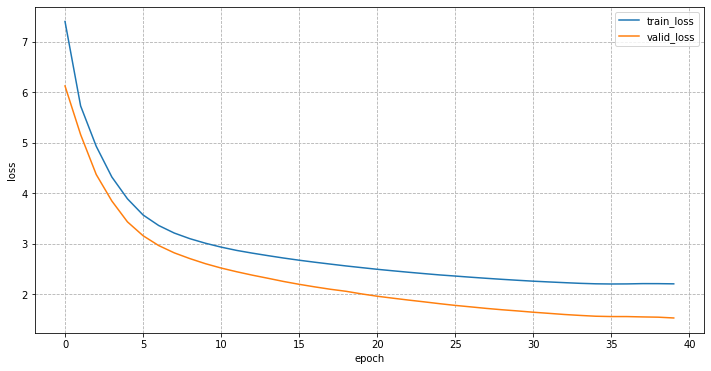

In [16]:
#打印loss曲线
plt.figure(figsize=(12,6))
plt.plot([i for i in range(len(train_loss))],[i.detach().cpu().numpy() for i in train_loss],label = "train_loss")
plt.plot([i for i in range(len(valid_loss))],[i.detach().cpu().numpy() for i in valid_loss],label = "valid_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(ls = '--')
plt.legend(loc = 'best')
plt.show()

# 8. 使用greedy_decode方法完成翻译任务，使用BLEU指标评价

这段代码的主要功能是对 Transformer 模型进行评估。先加载保存的模型参数，evaluate 函数会随机从测试集中选取 10 个句子进行翻译。其中greedy_decode 函数作用是对句子进行解码，返回翻译后的目标语言句子 ys。然后将中文词汇的索引转化为对应的中文词汇，打印翻译结果。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [17]:
# 对给定的源句子src进行解码，返回解码后的目标语句子。
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)  # 编码源句子得到记忆
    # 构造目标语言句子的第一个符号，并重复max_len-1次解码操作
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1): 
        # 解码，得到每个词的概率分布
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 从概率分布中选择最可能的下一个词
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # 将选择的下一个词加入目标语言句子中
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if data.cn_index_dict[next_word.item()] == "。":
            break
    return ys



# 定义 evaluate 函数，接受数据集 data 和模型 model 作为参数
def evaluate(data, model):
    # 禁止计算图梯度更新
    with torch.no_grad():
        # 随机从测试集 data.test_en 中抽取 10 个句子进行翻译
        for i in np.random.randint(len(data.test_en), size=10):
            # 将英文句子转化为单词，再用空格连接
            en_sent = " ".join([data.en_index_dict[w] for w in data.test_en[i]])
            # 打印英文句子
            print("\n" + en_sent)
            
            # 将中文句子转化为单词，再用空格连接
            cn_sent =  " ".join([data.cn_index_dict[w] for w in data.test_cn[i]])
            # 打印中文句子
            print("".join(cn_sent))
            print()
            # 将英文句子转化为 tensor，并放到设备上
            src = torch.from_numpy(np.array(data.test_en[i])).long().to(DEVICE)
            # 将 tensor 维度扩展为 [1, seq_len]，表示只有一句话
            src = src.unsqueeze(0)
            # 构造英文句子的掩码
            src_mask = (src != 0).unsqueeze(-2)
            # 使用 greedy_decode 函数对句子进行翻译
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # 对翻译结果进行后处理
            translation = []
            for j in range(1, out.size(1)):
                # 将中文词汇的索引转化为对应的词汇
                sym = data.cn_index_dict[out[0, j].item()]
                # 判断是否到达句子结尾，如果是则退出循环
                if sym != 'EOS':
                    translation.append(sym)
                else:
                    break
            # 打印翻译结果
            print("translation: {}".format(" ".join(translation)))
            
            
            
# 加载保存的模型参数
model.load_state_dict(torch.load(SAVE_FILE))
# 打印开始评估提示
print("start test")
# 获取评估开始时间
evaluate_start  = time.time()
# 调用 evaluate 函数对模型进行评估
evaluate(data, model)         
# 打印评估结束提示，以及评估耗时
print(f"finished test, cost {time.time()-evaluate_start:.4f} seconds")

start test

BOS indians like to think we can hold our own against the best in the world in any field : our UNK can stand up to their shakespeare , our UNK to their einstein , our bollywood to their hollywood and , these days , our infosys to their microsoft . EOS
BOS 印度人 喜欢 认为 我们 能 在 任何 领域 内 和 世界 上 最好 的 国家 竞争 ： 他们 有 莎士比亚 我们 UNK UNK ， 他们 有 爱因斯坦 我们 有 拉玛 UNK ， 他们 有 好莱坞 我们 UNK ， 现在 ， 他们 有 微软 我们 有 UNK UNK （ Infosys ） 。 EOS

translation: 我们 等 印度人 认为 我们 可以 在 任何 领域 领导 我们 自己 的 最佳 行动 ： 我们 可以 站 在 自己 的 理想 之下 ： 我们 可以 为 他们 的 柏林 ， 我们 把 爱因斯坦 的 物理学家 们 带到 他们 的 好莱坞 ， 而 我们 的 宝莱坞 影片 则 撰写 了 自己 的 电影 。

BOS we believe that this failure in our system is at the core of many interconnected issues we face as a society , and its resolution is key to a just future . EOS
BOS 我们 相信 该 系统 的 失灵 正是 这个 社会 当前 所 面对 的 许多 相联 问题 的 核心 ， 而 对此 的 解决方案 则 是 通往 一个 更 公平 未来 的 钥匙 。 EOS

translation: 我们 认为 ， 在 我们 的 体系 中 ， 这一 失败 是 我们 面临 的 众多 相互 关联 的 问题 的 核心 ， 而 其 决议 是 未来 的 关键 。

BOS in libya , col. muammar el-qaddafi ’ s wanton violence b

接下来使用贪心算法对测试集中英文句子进行翻译，并计算其与参考中文句子之间的BLEU分数，然后将所有句子的BLEU分数求平均并输出结果

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第九节课的配套源代码。

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compare_bleu_scores(data, model, n=10):
    greedy_bleu_scores = [] # 用于存储贪心算法下的BLEU分数

    with torch.no_grad():
        for i in range(n):
             # 准备英文句子和参考中文句子
            en_sent = data.test_en[i] # 英文句子
            reference = [data.cn_index_dict[w] for w in data.test_cn[i]][1:-1] # 参考中文句子

            # 编码英文句子并准备源掩码
            src = torch.from_numpy(np.array(en_sent)).long().to(DEVICE)
            src = src.unsqueeze(0)
            src_mask = (src != 0).unsqueeze(-2)

            # 使用贪心算法生成翻译
            max_output_len = int(len(en_sent)* 1.2)
            greedy_out = greedy_decode(model, src, src_mask, max_len=max_output_len, start_symbol=data.cn_word_dict["BOS"])
            # 将翻译从张量转换为单词列表，并去除末尾的EOS标记
            greedy_translation = [data.cn_index_dict[greedy_out[0, j].item()] for j in range(1, greedy_out.size(1)) if data.cn_index_dict[greedy_out[0, j].item()] != 'EOS']
            
            if i % 10 == 0:  # 打印前10个样本，您可以根据需要调整此数字
                print(f"Sample {i + 1}:")
                print(f"Input English sentence: {' '.join([data.en_index_dict[w] for w in en_sent])}")
                print(f"Reference Chinese sentence: {''.join(reference)}")
                print(f"Generated Chinese translation: {''.join(greedy_translation)}")
                print()
            
            # 计算BLEU分数
            smoothie = SmoothingFunction().method1
            greedy_bleu = sentence_bleu([reference], greedy_translation, smoothing_function=smoothie)

            # 将BLEU分数添加到列表中
            greedy_bleu_scores.append(greedy_bleu)

    # 计算平均BLEU分数
    avg_greedy_bleu = sum(greedy_bleu_scores) / len(greedy_bleu_scores)

    return avg_greedy_bleu

# 调用函数来比较BLEU分数
greedy_bleu = compare_bleu_scores(data, model, n=3000)

Sample 1:
Input English sentence: BOS 1.6 EOS
Reference Chinese sentence: 1. 6
Generated Chinese translation: 1.

Sample 11:
Input English sentence: BOS not really . EOS
Reference Chinese sentence: UNK。
Generated Chinese translation: 不。

Sample 21:
Input English sentence: BOS perhaps not . EOS
Reference Chinese sentence: 也许不是。
Generated Chinese translation: 也许不。

Sample 31:
Input English sentence: BOS the second nuclear age EOS
Reference Chinese sentence: 第二核时代
Generated Chinese translation: 第二次核时代

Sample 41:
Input English sentence: BOS they are mistaken . EOS
Reference Chinese sentence: 他们的想法是错误的。
Generated Chinese translation: 它们是错误的。

Sample 51:
Input English sentence: BOS most russians look westward . EOS
Reference Chinese sentence: 大多数俄国人向往西方。
Generated Chinese translation: 俄罗斯人眼中的是西方国家

Sample 61:
Input English sentence: BOS iran ’ s revolutionary echoes EOS
Reference Chinese sentence: 伊朗的革命回响
Generated Chinese translation: 伊朗的革命被误解了

Sample 71:
Input English sentence: BOS the p

In [19]:
print(f"Average BLEU score with greedy decoding: {greedy_bleu:.4f}")

Average BLEU score with greedy decoding: 0.1404


# 9. 打印模型翻译结果和BLEU评分，思考评分低的原因以及改进措施。

1. 数据预处理：观察到数据集中有很多不规范的训练材料，训练前应该先对数据集进行合适的清洗，去除异常值和不相关的数据。

2. 模型架构和超参数：可以尝试调整模型的超参数，如隐藏层大小、多头注意力的头数、编码器和解码器层数、学习率优化系数等。可以考虑在模型中使用预训练的词嵌入，如GloVe或word2vec。

3. 训练策略：应该增加更多的训练轮次，确保模型充分收敛。

4. 解码策略：这个例子使用了贪婪解码（greedy decoding）策略。贪婪解码在每个时间步选择概率最高的单词作为输出，这种方法可能导致次优解，因为它没有考虑到整个句子的概率分布。可以改进使用更复杂的解码策略，如beam search。

5. BLEU评分的限制：BLEU评分主要关注n-gram匹配，可能不能完全捕捉到句子的语义和结构。因此，在某些情况下，即使生成的翻译在语义上是正确的，BLEU评分也可能较低。可以尝试使用其他评估指标，如ROUGE、METEOR等，以获得更全面的评估结果。

6. 更多数据和预训练模型：目前数据集局限于新闻领域，可以进一步考虑扩充涵盖其它领域更大规模的数据集。尝试使用预训练的翻译模型，如OpenAI的GPT或Facebook的MarianMT，它们已经在大量数据上进行了预训练。
